# Association between stroke and psychosis across four nationally representative epidemiological studies

This is the analysis code for the above named paper with embedded results. This is a Jupyter notebook which can be re-run to reproduce the same results when accompanied by the same data

In [42]:
# Load R packages
library(dplyr)
library(foreign)
library(jtools)
library(table1)
library(epiR)
library(lme4)
library(IRdisplay)

In [2]:
verbose_reporting <- FALSE
options(warn=-1)

## Loading and recoding of national datasets

### Adult Psychiatric Morbidity Survey 2007 (England, United Kingdom)

In [3]:
# Load data
#
spssfile <- "./Data/apms2007/apms07arch.sav" 
apms_complete <- read.spss(spssfile, to.data.frame = TRUE, use.value.labels = FALSE)

# Select variables
#
dataset_apms <- select(apms_complete, 
                  age = ResAge, sex = ResSex,
                  paranoia = PSQ3a, # Felt that people were directly acting to harm you / your interests
                  hearvoices = PSQ5a,  # Heard voices saying quite a few words of sentences
                  thoughtpass = PSQ2a,  # Ever felt thoughts were directly interfered with by some outside force or person in past year
                  stroke = HDoct9, # by medic
                  highest_ed = EDQUAL5,
                  sample_weight = wt_ints1)

# Label dataset
#
dataset_apms$dataset_name <- 'apms'

# Recode stroke variable
#
dataset_apms$stroke[dataset_apms$stroke==1] <- 1  # Yes
dataset_apms$stroke[dataset_apms$stroke==2] <- 0  # No
dataset_apms$stroke[is.na(dataset_apms$stroke)] <- 0  # No evidence
dataset_apms$stroke <- factor(dataset_apms$stroke, levels = c(1,0), labels = c(" yes", " no")) 

# Recode psychotic symptom variables
#
dataset_apms$paranoia[dataset_apms$paranoia==3] <- 0  # unsure = no
dataset_apms$paranoia[dataset_apms$paranoia==1] <- 1  # Yes
dataset_apms$paranoia[dataset_apms$paranoia==2] <- 0  # No
dataset_apms$paranoia[is.na(dataset_apms$paranoia)] <- 0  # No evidence

dataset_apms$hearvoices[dataset_apms$hearvoices==3] <- 0    # unsure = no
dataset_apms$hearvoices[dataset_apms$hearvoices==1] <- 1    # Yes
dataset_apms$hearvoices[dataset_apms$hearvoices==2] <- 0    # No
dataset_apms$hearvoices[is.na(dataset_apms$hearvoices)] <- 0  # No evidence

dataset_apms$thoughtpass[dataset_apms$thoughtpass==3] <- 0  # unsure = no
dataset_apms$thoughtpass[dataset_apms$thoughtpass==1] <- 1  # Yes
dataset_apms$thoughtpass[dataset_apms$thoughtpass==2] <- 0  # No
dataset_apms$thoughtpass[is.na(dataset_apms$thoughtpass)] <- 0  # No evidence

# Calculate probable psychosis variable
#
dataset_apms$psychosis_tot <- rowSums(dataset_apms[,c("paranoia", "hearvoices", "thoughtpass")], na.rm=TRUE)
dataset_apms$prob_psychosis[dataset_apms$psychosis_tot >= 2] <- 1
dataset_apms$prob_psychosis[dataset_apms$psychosis_tot <= 1] <- 0
dataset_apms$psychosis_tot <- NULL

# Set types for psychosis variables
#
dataset_apms$paranoia <- factor(dataset_apms$paranoia, levels = c(1,0), labels = c(" yes", " no")) 
dataset_apms$hearvoices <- factor(dataset_apms$hearvoices, levels = c(1,0), labels = c(" yes", " no")) 
dataset_apms$thoughtpass <- factor(dataset_apms$thoughtpass, levels = c(1,0), labels = c(" yes", " no")) 
dataset_apms$prob_psychosis <- factor(dataset_apms$prob_psychosis, levels = c(1,0), labels = c(" yes", " no")) 

# Recode and set variable type for highest level of education
#
dataset_apms <- dataset_apms %>%
  mutate(highest_ed = recode(highest_ed,
                              `1` = 4,  # College / uni
                              `2` = 4,  # College / uni
                              `3` = 3,  # Late teen high school
                              `4` = 2,  # Mid teen high school
                              `5` = 2,  # "Foreign / other" coded as Mid teen high school
                              `6` = 1)) # No or primary education

dataset_apms$highest_ed <- factor(dataset_apms$highest_ed,
                                      levels = c(1, 2, 3, 4),
                                      labels = c("No / primary education", "Mid-teen high school", "Late teen high school", "College / university")) 

# Set variable type for sex
#
dataset_apms$sex <- factor(dataset_apms$sex, levels = c(1,2), labels = c(" male", " female")) 

# Give variables formatted variable names for table
#
label(dataset_apms$sex) <- "Sex"
label(dataset_apms$age) <- "Age"
label(dataset_apms$highest_ed) <- "Highest level of education"
label(dataset_apms$stroke) <- "Stroke"
label(dataset_apms$prob_psychosis) <- "Prob.Psychosis"

# Remove intermediary memory objects
#
rm(apms_complete)

### Collaborative Psychiatric Epidemiology Surveys 2001-2003 (United States)

In [4]:
# Load data
#
d1_filename <- "./Data/ICPSR_20240/DS0001/20240-0001-Data.tsv"
d3_filename <- "./Data/ICPSR_20240/DS0003/20240-0003-Data.tsv"

d1_df <- read.csv(d1_filename, sep="\t", header=T)
d3_df <- read.csv(d3_filename, sep="\t", header=T)

# Select variables
#
d1_select_df <- select(d1_df, 
                       caseid = CASEID, 
                       sex = V09036,
                       age = V07306)

d3_select_df <- select(d3_df, 
                       caseid = CASEID,
                       stroke = C10H,  # by medic
                       highest_ed = H13,
                       paranoia = PS1F, # Unjust plot to harm you/have people follow-nobody believe
                       hearvoices = PS1B,  # Ever hear voices others couldn't hear
                       thoughtpass = PS1C) # Ever have mind control experience

# Merge datasets 
#
dataset_cpes <- merge(d1_select_df, d3_select_df, by="caseid")

# Label dataset
#
dataset_cpes$dataset_name <- 'cpes'

# Recode stroke variable
#
dataset_cpes$stroke[dataset_cpes$stroke == 1 ] <- 1
dataset_cpes$stroke[dataset_cpes$stroke == 5 ] <- 0
dataset_cpes$stroke[dataset_cpes$stroke == -8 ] <- 0
dataset_cpes$stroke[dataset_cpes$stroke == -9 ] <- 0
dataset_cpes$stroke <- factor(dataset_cpes$stroke, levels = c(1,0), labels = c(" yes", " no")) 

# Recode psychotic symptom variables
#
# Note: NAs replaced by zeros because random forest imputation imputed all NAs as zeros.
# See CPESVariableImputationCheck.R for code
#
dataset_cpes$paranoia[dataset_cpes$paranoia == 1 ] <- 1
dataset_cpes$paranoia[dataset_cpes$paranoia == 5 ] <- 0
dataset_cpes$paranoia[dataset_cpes$paranoia == -8 ] <- 0
dataset_cpes$paranoia[dataset_cpes$paranoia == -9 ] <- 0

dataset_cpes$hearvoices[dataset_cpes$hearvoices == 1 ] <- 1
dataset_cpes$hearvoices[dataset_cpes$hearvoices == 5 ] <- 0
dataset_cpes$hearvoices[dataset_cpes$hearvoices == -8 ] <- 0
dataset_cpes$hearvoices[dataset_cpes$hearvoices == -9 ] <- 0

dataset_cpes$thoughtpass[dataset_cpes$thoughtpass == 1 ] <- 1
dataset_cpes$thoughtpass[dataset_cpes$thoughtpass == 5 ] <- 0
dataset_cpes$thoughtpass[dataset_cpes$thoughtpass == -8 ] <- 0
dataset_cpes$thoughtpass[dataset_cpes$thoughtpass == -9 ] <- 0

# Calculate probable psychosis variable
#
dataset_cpes$psychosis_tot <- rowSums(dataset_cpes[,c("paranoia", "hearvoices", "thoughtpass")], na.rm=TRUE)
dataset_cpes$prob_psychosis[dataset_cpes$psychosis_tot >= 2] <- 1
dataset_cpes$prob_psychosis[dataset_cpes$psychosis_tot <= 1] <- 0
dataset_cpes$psychosis_tot <- NULL

# Set types for psychosis variables
#
dataset_cpes$paranoia <- factor(dataset_cpes$paranoia, levels = c(1,0), labels = c(" yes", " no")) 
dataset_cpes$hearvoices <- factor(dataset_cpes$hearvoices, levels = c(1,0), labels = c(" yes", " no")) 
dataset_cpes$thoughtpass <- factor(dataset_cpes$thoughtpass, levels = c(1,0), labels = c(" yes", " no")) 
dataset_cpes$prob_psychosis <- factor(dataset_cpes$prob_psychosis, levels = c(1,0), labels = c(" yes", " no")) 

# Recode and set variable type for highest level of education
#
dataset_cpes$highest_ed[dataset_cpes$highest_ed <= 9] <- 1 # Basic
dataset_cpes$highest_ed[dataset_cpes$highest_ed==10] <- 2  # Mid teen high school
dataset_cpes$highest_ed[dataset_cpes$highest_ed==11] <- 2  # Mid teen high school
dataset_cpes$highest_ed[dataset_cpes$highest_ed==12] <- 3  # Late teen high school
dataset_cpes$highest_ed[dataset_cpes$highest_ed==13] <- 3  # Late teen high school 
dataset_cpes$highest_ed[dataset_cpes$highest_ed==14] <- 3  # Late teen high school 
dataset_cpes$highest_ed[dataset_cpes$highest_ed==15] <- 3  # Late teen high school 
dataset_cpes$highest_ed[dataset_cpes$highest_ed==16] <- 4  # College / uni
dataset_cpes$highest_ed[dataset_cpes$highest_ed==17] <- 4  # College / uni

dataset_cpes$highest_ed <- factor(dataset_cpes$highest_ed,
                                  levels = c(1, 2, 3, 4),
                                  labels = c("No / primary education", "Mid-teen high school", "Late teen high school", "College / university")) 

# Set variable type for sex
#
dataset_cpes$sex <- factor(dataset_cpes$sex,
                           levels = c(1,2),
                           labels = c(" male", " female")) 

# Give variables formatted variable names for table
#
label(dataset_cpes$sex) <- "Sex"
label(dataset_cpes$age) <- "Age"
label(dataset_cpes$highest_ed) <- "Highest level of education"
label(dataset_cpes$stroke) <- "Stroke"
label(dataset_cpes$prob_psychosis) <- "Prob.Psychosis"

# Remove intermediary memory objects
#
rm(d1_df, d3_df, d1_select_df, d3_select_df)

### National Mental Health Survey 2015 (Colombia)

In [5]:
# Load data
#
personas_datafile = "./Data/ensm2015/Personas.txt"
personas_df <- read.csv(personas_datafile, header = TRUE, sep='|', stringsAsFactors = FALSE, na.strings=c("NULL","900","950"))

adultos1_datafile = "./Data/ensm2015/Adultos_I.txt"
adultos1_df <- read.csv(adultos1_datafile, header = TRUE, sep='|', stringsAsFactors = FALSE, na.strings=c("NULL","900","950"))

adultos2_datafile = "./Data/ensm2015/Adultos_II.txt"
adultos2_df <- read.csv(adultos2_datafile, header = TRUE, sep='|', stringsAsFactors = FALSE, na.strings=c("NULL","900","950"))

# Merge datasets
#
merged_df <- merge(personas_df, adultos1_df, by="identificador_persona")
merged_df <- merge(merged_df, adultos2_df, by="identificador_persona")

# Select variables
#
dataset_ensm <- select(merged_df, 
                       identificador_persona,
                       age = age.x,
                       sex = sex.x,
                       paranoia = m7_p21,  # ¿Siente que alguien ha tratado de herirlo en alguna forma?
                       hearvoices = m7_p24,   # ¿Oye voces sin saber de dónde vienen o que otras personas no pueden oír?
                       thoughtpass = m7_p23,  # ¿Ha notado interferencias o algo raro en su pensamiento?
                       highest_ed = NivelEducativo.x,
                       stroke = m5_p38)

# Label dataset
#
dataset_ensm$dataset_name <- 'ensm'

# Recode stroke variable
#
dataset_ensm$stroke[dataset_ensm$stroke==2] <- 0
dataset_ensm$stroke <- factor(dataset_ensm$stroke, levels = c(1,0), labels = c(" yes", " no")) 

# Recode psychotic symptom variables
#
dataset_ensm$paranoia[dataset_ensm$paranoia==2] <- 0
dataset_ensm$hearvoices[dataset_ensm$hearvoices==2] <- 0  
dataset_ensm$thoughtpass[dataset_ensm$thoughtpass==2] <- 0

# Calculate probable psychosis variable
#
dataset_ensm$psychosis_tot <- rowSums(dataset_ensm[,c("paranoia", "hearvoices", "thoughtpass")], na.rm=TRUE)
dataset_ensm$prob_psychosis[dataset_ensm$psychosis_tot >= 2] <- 1
dataset_ensm$prob_psychosis[dataset_ensm$psychosis_tot <= 1] <- 0
dataset_ensm$psychosis_tot <- NULL

# Set types for psychosis variables
#
dataset_ensm$paranoia <- factor(dataset_ensm$paranoia, levels = c(1,0), labels = c(" yes", " no")) 
dataset_ensm$hearvoices <- factor(dataset_ensm$hearvoices, levels = c(1,0), labels = c(" yes", " no")) 
dataset_ensm$thoughtpass <- factor(dataset_ensm$thoughtpass, levels = c(1,0), labels = c(" yes", " no")) 
dataset_ensm$prob_psychosis <- factor(dataset_ensm$prob_psychosis, levels = c(1,0), labels = c(" yes", " no")) 

# Recode and set variable type for highest level of education
#
dataset_ensm$highest_ed[dataset_ensm$highest_ed == 1] <- 1 # Basic
dataset_ensm$highest_ed[dataset_ensm$highest_ed == 2] <- 2 # Mid teen high school
dataset_ensm$highest_ed[dataset_ensm$highest_ed == 3] <- 3 # Late teen high school
dataset_ensm$highest_ed[dataset_ensm$highest_ed == 4] <- 4 # College / uni

dataset_ensm$highest_ed <- factor(dataset_ensm$highest_ed,
                                  levels = c(1, 2, 3, 4),
                                  labels = c("No / primary education", "Mid-teen high school", "Late teen high school", "College / university")) 

# Set variable type for sex
#
dataset_ensm$sex <- factor(dataset_ensm$sex, levels = c(1,2), labels = c(" male", " female")) 

# Give variables formatted variable names for table
#
label(dataset_ensm$sex) <- "Sex"
label(dataset_ensm$age) <- "Age"
label(dataset_ensm$highest_ed) <- "Highest level of education"
label(dataset_ensm$stroke) <- "Stroke"
label(dataset_ensm$prob_psychosis) <- "Prob.Psychosis"

# Remove intermediary memory objects
#
rm(personas_df, adultos1_df, adultos2_df, merged_df)

### National Health Survey 2016-2017 (Chile)

In [6]:
# Load data
#
spssfile <- "./Data/ensc_2016-2017/Base de datos Encuesta Nacional de Salud 2016-2017(ENS).Formulario 1_2_EX.MINSAL_EPI. (2).sav"
ensc_f1_complete <- read.spss(spssfile, to.data.frame = TRUE, use.value.labels = FALSE)

spssfile <- "./Data/ensc_2016-2017/diag_main_v8_spss_11102019.sav"
ensc_dx_complete <- read.spss(spssfile, to.data.frame = TRUE, use.value.labels = FALSE)

# Select variables
#
dataset_ensc_f1 <- select(ensc_f1_complete, 
                          caseid = IdEncuesta,
                          age = Edad,
                          sex = Sexo,
                          stroke = d4) # by medic

dataset_ensc_dx <- select(ensc_dx_complete, 
                          caseid = IdEncuesta,
                          paranoia = PS1f, # ¿Alguna vez pensó que había una conspiración para hacerle daño o perseguirlo y que su familia o amigos no creyeran que esto fuera real?
                          hearvoices = PS1b,  # La segunda experiencia es oír voces que otras personas no podían oír. ¿Alguna vez le ha pasado algo como esto? 
                          thoughtpass = PS1c, # La tercera experiencia tiene que ver con control de la mente. 
                          highest_ed = NEDU2_MINSAL_1)

# Merge datasets
#
dataset_ensc <- merge(dataset_ensc_f1, dataset_ensc_dx, by="caseid")

# Label dataset
#
dataset_ensc$dataset_name <- 'ensc'

# Recode stroke variable
#
dataset_ensc$stroke[dataset_ensc$stroke == 1 ] <- 1
dataset_ensc$stroke[dataset_ensc$stroke == 2 ] <- 0
dataset_ensc$stroke <- factor(dataset_ensc$stroke, levels = c(1,0), labels = c(" yes", " no")) 

# Recode psychotic symptom variables
#
dataset_ensc$paranoia[dataset_ensc$paranoia == 1 ] <- 1
dataset_ensc$paranoia[dataset_ensc$paranoia == 5 ] <- 0
dataset_ensc$paranoia[dataset_ensc$paranoia == 8 ] <- 0
dataset_ensc$paranoia[dataset_ensc$paranoia == 9 ] <- 0

dataset_ensc$hearvoices[dataset_ensc$hearvoices == 1 ] <- 1
dataset_ensc$hearvoices[dataset_ensc$hearvoices == 5 ] <- 0
dataset_ensc$hearvoices[dataset_ensc$hearvoices == 8 ] <- 0
dataset_ensc$hearvoices[dataset_ensc$hearvoices == 9 ] <- 0

dataset_ensc$thoughtpass[dataset_ensc$thoughtpass == 1 ] <- 1
dataset_ensc$thoughtpass[dataset_ensc$thoughtpass == 5 ] <- 0
dataset_ensc$thoughtpass[dataset_ensc$thoughtpass == 8 ] <- 0
dataset_ensc$thoughtpass[dataset_ensc$thoughtpass == 9 ] <- 0

# Calculate probable psychosis variable
#
dataset_ensc$psychosis_tot <- rowSums(dataset_ensc[,c("paranoia", "hearvoices", "thoughtpass")], na.rm=TRUE)
dataset_ensc$prob_psychosis[dataset_ensc$psychosis_tot >= 2] <- 1
dataset_ensc$prob_psychosis[dataset_ensc$psychosis_tot <= 1] <- 0
dataset_ensc$psychosis_tot <- NULL

# Set types for psychosis variables
#
dataset_ensc$paranoia <- factor(dataset_ensc$paranoia, levels = c(1,0), labels = c(" yes", " no")) 
dataset_ensc$hearvoices <- factor(dataset_ensc$hearvoices, levels = c(1,0), labels = c(" yes", " no")) 
dataset_ensc$thoughtpass <- factor(dataset_ensc$thoughtpass, levels = c(1,0), labels = c(" yes", " no")) 
dataset_ensc$prob_psychosis <- factor(dataset_ensc$prob_psychosis, levels = c(1,0), labels = c(" yes", " no")) 

# Recode and set variable type for highest level of education
#
dataset_ensc$highest_ed[dataset_ensc$highest_ed == 1] <- 1 # Basic
dataset_ensc$highest_ed[dataset_ensc$highest_ed == 2] <- 1 # Basic
dataset_ensc$highest_ed[dataset_ensc$highest_ed == 3] <- 2 # Mid teen high school
dataset_ensc$highest_ed[dataset_ensc$highest_ed == 4] <- 2 # Mid teen high school
dataset_ensc$highest_ed[dataset_ensc$highest_ed == 5] <- 3 # Late teen high school
dataset_ensc$highest_ed[dataset_ensc$highest_ed == 6] <- 3 # Late teen high school
dataset_ensc$highest_ed[dataset_ensc$highest_ed == 7] <- 4 # College / uni
dataset_ensc$highest_ed[dataset_ensc$highest_ed == 8] <- 4 # College / uni
dataset_ensc$highest_ed[dataset_ensc$highest_ed == 9] <- 4 # College / uni
dataset_ensc$highest_ed[dataset_ensc$highest_ed == 10] <- 4 # College / uni

dataset_ensc$highest_ed <- factor(dataset_ensc$highest_ed,
                                  levels = c(1, 2, 3, 4),
                                  labels = c("No / primary education", "Mid-teen high school", "Late teen high school", "College / university")) 

# Set variable type for sex
#
dataset_ensc$sex <- factor(dataset_ensc$sex, levels = c(1,2), labels = c(" male", " female")) 

# Give variables formatted variable names for table
#
label(dataset_ensc$sex) <- "Sex"
label(dataset_ensc$age) <- "Age"
label(dataset_ensc$highest_ed) <- "Highest level of education"
label(dataset_ensc$stroke) <- "Stroke"
label(dataset_ensc$prob_psychosis) <- "Prob.Psychosis"

# Remove intermediary memory objects
#
rm(ensc_f1_complete, ensc_dx_complete, dataset_ensc_f1, dataset_ensc_dx)

re-encoding from CP1252



### Create combined countries dataset

In [7]:
# Select relevant variables from each national dataset
#
subset_apms <- select(dataset_apms,
                      dataset_name,
                      sex, age,
                      stroke, prob_psychosis, 
                      paranoia, hearvoices, thoughtpass,
                      highest_ed)
subset_cpes <- select(dataset_cpes,
                      dataset_name,
                      sex, age,
                      stroke, prob_psychosis, 
                      paranoia, hearvoices, thoughtpass,
                      highest_ed)
subset_ensm <- select(dataset_ensm,
                      dataset_name,
                      sex, age,
                      stroke, prob_psychosis, 
                      paranoia, hearvoices, thoughtpass,
                      highest_ed)
subset_ensc <- select(dataset_ensc,
                      dataset_name,
                      sex, age,
                      stroke, prob_psychosis, 
                      paranoia, hearvoices, thoughtpass,
                      highest_ed)

# ...and combine into one combined countries dataset
#
dataset_combined <- rbind(subset_apms, subset_cpes)
dataset_combined <- rbind(dataset_combined, subset_ensm)
dataset_combined <- rbind(dataset_combined, subset_ensc)

# Remove intermediary memory objects
#
rm(subset_apms, subset_ensm, subset_cpes, subset_ensc)

## Functions to calculate prevalences

#### Calculate stroke prevalence in total population

In [8]:
calc_stroke_prevalence <- function(prev_df) {
  # How many people have stroke in the total population?
  tbobj <- as.numeric(table(prev_df$stroke))
  nstrokecases <- tbobj[1]; npopulation <- sum(tbobj)
  prev_matrix <- as.matrix(cbind(nstrokecases, npopulation))
  
  # Calculate prevalence
  prev_est <- epi.conf(prev_matrix, ctype = "prevalence", method = "exact", N = nrow(prev_df), design = 1, 
                       conf.level = 0.95) * 100
  est_plus_95CI <- sprintf("%.2f%% (%.2f - %.2f)", prev_est$est, prev_est$lower, prev_est$upper)
  est_plus_95CI
}

#### Calculate probable psychosis prevalence in total population

In [9]:
calc_probpsychosis_prevalence <- function(prev_df) {
  # How many people have probable psychosis in the total population?
  tbobj <- as.numeric(table(prev_df$prob_psychosis))
  nprobpsychosiscases <- tbobj[1]; npopulation <- sum(tbobj)
  prev_matrix <- as.matrix(cbind(nprobpsychosiscases, npopulation))
  
  # Calculate prevalence
  prev_est <- epi.conf(prev_matrix, ctype = "prevalence", method = "exact", N = nrow(prev_df), design = 1, 
                       conf.level = 0.95) * 100
  est_plus_95CI <- sprintf("%.2f%% (%.2f - %.2f)", prev_est$est, prev_est$lower, prev_est$upper)
  est_plus_95CI
}

#### Calculate prevalence of probable psychosis in stroke population

In [10]:
calc_probpsychosis_in_stroke_prevalence <- function(prev_df) {
  # How many people have stroke?
  stroke_table <- as.numeric(table(prev_df$stroke))
  stroke_pop <- stroke_table[1]
  
  # How many people who have stroke have psychosis?
  stroke_psychosis_table <- as.numeric(table(prev_df$stroke, prev_df$prob_psychosis))
  psychosis_in_stroke_cases <- stroke_psychosis_table[1]
  prev_matrix <- as.matrix(cbind(psychosis_in_stroke_cases, stroke_pop))
  
  # Calculate prevalence
  prev_est <- epi.conf(prev_matrix, ctype = "prevalence", method = "exact", N = nrow(prev_df), design = 1, 
                       conf.level = 0.95) * 100
  prev_est
  est_plus_95CI <- sprintf("%.2f%% (%.2f - %.2f)", prev_est$est, prev_est$lower, prev_est$upper)
  est_plus_95CI
}

#### Calculate prevalence of stroke in probable psychosis population

In [11]:
calc_stroke_in_probpsychosis_prevalence <- function(prev_df) {
  # How many people have probable psychosis?
  psychosis_table <- as.numeric(table(prev_df$prob_psychosis))
  psychosis_pop <- psychosis_table[1]
  
  # How many people who have probable psychosis have stroke?
  psychosis_stroke_table <- as.numeric(table(prev_df$prob_psychosis, prev_df$stroke))
  stroke_in_psychosis_cases <- psychosis_stroke_table[1]
  prev_matrix <- as.matrix(cbind(stroke_in_psychosis_cases, psychosis_pop))
  
  # Calculate prevalence
  prev_est <- epi.conf(prev_matrix, ctype = "prevalence", method = "exact", N = nrow(prev_df), design = 1, 
                       conf.level = 0.95) * 100
  prev_est
  est_plus_95CI <- sprintf("%.2f%% (%.2f - %.2f)", prev_est$est, prev_est$lower, prev_est$upper)
  est_plus_95CI
}

## Functions to run regression models

#### Regression models testing unadjusted and adjusted associations between stroke and probable psychosis in national datasets

In [12]:
run_prob_psychosis_models <- function(funcdf) {
  # Unadjusted
  test_model <- glm(prob_psychosis ~ stroke, data = funcdf, family = binomial(link = "logit"), maxit=500)
  summ_of_model <- summ(test_model, exp = TRUE, digits = 4)
  un_prob_psychosis_OR_CIs <- sprintf("%.2f (%.2f - %.2f)", summ_of_model$coeftable[2], summ_of_model$coeftable[4], summ_of_model$coeftable[6])

  # Adjusted by sex, age, education
  test_model <- glm(prob_psychosis ~ stroke + sex + age + highest_ed, data = funcdf, family = binomial(link = "logit"), maxit=500)
  summ_of_model <- summ(test_model, exp = TRUE, digits = 4)
  adj_ed_prob_psychosis_OR_CIs <- sprintf("%.2f (%.2f - %.2f)", summ_of_model$coeftable[2], summ_of_model$coeftable[9], summ_of_model$coeftable[16])

  prob_psychosis_results <- c(un_prob_psychosis_OR_CIs,
                              adj_ed_prob_psychosis_OR_CIs)
  prob_psychosis_results
}

#### Multi-level regression models testing unadjusted and adjusted associations between stroke and probable psychosis in combined countries dataset

In [13]:
run_prob_psychosis_combined_model <- function(funcdf) {
  # Unadjusted
  test_model <- glmer(prob_psychosis ~ stroke + (1|dataset_name),
                      data = dataset_combined,
                      family = binomial(link = "logit"),
                      control = glmerControl(tolPwrss=1e-3))
  test_model_CIs <- confint(test_model, parm="beta_", method="Wald")
  test_model_table <- cbind(est=fixef(test_model),test_model_CIs)
  test_model_table_OR <- exp(test_model_table)
  un_prob_psychosis_OR_CIs <- sprintf("%.2f (%.2f - %.2f)", test_model_table_OR[2], test_model_table_OR[4], test_model_table_OR[6])

  # Adjusted by sex, age, education
  test_model <- glmer(prob_psychosis ~ stroke + sex + age + highest_ed + (1|dataset_name),
                      data = dataset_combined,
                      family = binomial(link = "logit"),
                      control = glmerControl(tolPwrss=1e-3))
  test_model_CIs <- confint(test_model, parm="beta_", method="Wald")
  test_model_table <- cbind(est=fixef(test_model),test_model_CIs)
  test_model_table_OR <- exp(test_model_table)
  adj_ed_prob_psychosis_OR_CIs <- sprintf("%.2f (%.2f - %.2f)", test_model_table_OR[2], test_model_table_OR[9], test_model_table_OR[16])

  prob_psychosis_combined_results <- c(un_prob_psychosis_OR_CIs,
                                       adj_ed_prob_psychosis_OR_CIs)
  prob_psychosis_combined_results
}

#### Regression models testing unadjusted and adjusted associations between stroke and paranoia in national datasets

In [14]:
run_paranoia_models <- function(funcdf) {
  # Unadjusted
  test_model <- glm(paranoia ~ stroke, data = funcdf, family = binomial(link = "logit"))
  summ_of_model <- summ(test_model, exp = TRUE, digits = 4)
  un_paranoia_OR_CIs <- sprintf("%.2f (%.2f - %.2f)", summ_of_model$coeftable[2], summ_of_model$coeftable[4], summ_of_model$coeftable[6])

  # Adjusted by sex, age, education
  test_model <- glm(paranoia ~ stroke + sex + age + highest_ed, data = funcdf, family = binomial(link = "logit"))
  summ_of_model <- summ(test_model, exp = TRUE, digits = 4)
  adj_ed_paranoia_OR_CIs <- sprintf("%.2f (%.2f - %.2f)", summ_of_model$coeftable[2], summ_of_model$coeftable[9], summ_of_model$coeftable[16])

  paranoia_results <- c(un_paranoia_OR_CIs,
                           adj_ed_paranoia_OR_CIs)
  paranoia_results
}

#### Multi-level regression models testing unadjusted and adjusted associations between stroke and paranoia in combined countries dataset

In [15]:
run_paranoia_combined_model <- function(funcdf) {
  # Unadjusted
  test_model <- glmer(paranoia ~ stroke + (1|dataset_name),
                      data = funcdf,
                      family = binomial(link = "logit"),
                      control = glmerControl(tolPwrss=1e-3))
  test_model_CIs <- confint(test_model, parm="beta_", method="Wald")
  test_model_table <- cbind(est=fixef(test_model),test_model_CIs)
  test_model_table_OR <- exp(test_model_table)
  un_paranoia_OR_CIs <- sprintf("%.2f (%.2f - %.2f)", test_model_table_OR[2], test_model_table_OR[4], test_model_table_OR[6])

  # Adjusted by sex, age, education
  test_model <- glmer(paranoia ~ stroke + sex + age + highest_ed + (1|dataset_name),
                      data = funcdf,
                      family = binomial(link = "logit"),
                      control = glmerControl(tolPwrss=1e-3))
  test_model_CIs <- confint(test_model, parm="beta_", method="Wald")
  test_model_table <- cbind(est=fixef(test_model),test_model_CIs)
  test_model_table_OR <- exp(test_model_table)
  adj_ed_paranoia_OR_CIs <- sprintf("%.2f (%.2f - %.2f)", test_model_table_OR[2], test_model_table_OR[9], test_model_table_OR[16])

  paranoia_combined_results <- c(un_paranoia_OR_CIs,
                                    adj_ed_paranoia_OR_CIs)
  paranoia_combined_results
}

#### Regression models testing unadjusted and adjusted association between stroke and hallucinated voices in national datasets

In [16]:
run_hearvoices_models <- function(funcdf) {
  # Unadjusted
  test_model <- glm(hearvoices ~ stroke, data = funcdf, family = binomial(link = "logit"))
  summ_of_model <- summ(test_model, exp = TRUE, digits = 4)
  un_hearvoices_OR_CIs <- sprintf("%.2f (%.2f - %.2f)", summ_of_model$coeftable[2], summ_of_model$coeftable[4], summ_of_model$coeftable[6])

  # Adjusted by sex, age and education
  test_model <- glm(hearvoices ~ stroke + sex + age + highest_ed, data = funcdf, family = binomial(link = "logit"))
  summ_of_model <- summ(test_model, exp = TRUE, digits = 4)
  adj_ed_hearvoices_OR_CIs <- sprintf("%.2f (%.2f - %.2f)", summ_of_model$coeftable[2], summ_of_model$coeftable[9], summ_of_model$coeftable[16])

  hearvoices_results <- c(un_hearvoices_OR_CIs,
                          adj_ed_hearvoices_OR_CIs)
  hearvoices_results
}

#### Multi-level regression models testing unadjusted and adjusted associations between stroke and paranoia in combined countries dataset

In [17]:
run_hearvoices_combined_model <- function(funcdf) {
  # Unadjusted
  test_model <- glmer(hearvoices ~ stroke + (1|dataset_name),
                      data = funcdf,
                      family = binomial(link = "logit"),
                      control = glmerControl(tolPwrss=1e-3))
  test_model_CIs <- confint(test_model, parm="beta_", method="Wald")
  test_model_table <- cbind(est=fixef(test_model),test_model_CIs)
  test_model_table_OR <- exp(test_model_table)
  un_hearvoices_OR_CIs <- sprintf("%.2f (%.2f - %.2f)", test_model_table_OR[2], test_model_table_OR[4], test_model_table_OR[6])

  # Adjusted by sex, age, education
  test_model <- glmer(hearvoices ~ stroke + sex + age + highest_ed + (1|dataset_name),
                      data = funcdf,
                      family = binomial(link = "logit"),
                      control = glmerControl(tolPwrss=1e-3))
  test_model_CIs <- confint(test_model, parm="beta_", method="Wald")
  test_model_table <- cbind(est=fixef(test_model),test_model_CIs)
  test_model_table_OR <- exp(test_model_table)
  adj_ed_hearvoices_OR_CIs <- sprintf("%.2f (%.2f - %.2f)", test_model_table_OR[2], test_model_table_OR[9], test_model_table_OR[16])

  hearvoices_combined_results <- c(un_hearvoices_OR_CIs,
                                    adj_ed_hearvoices_OR_CIs)
  hearvoices_combined_results
}

#### Regression models testing unadjusted and adjusted associations between stroke and thought passivity delusions in national datasets

In [18]:
run_thoughtpass_models <- function(funcdf) {
  # Unadjusted
  test_model <- glm(thoughtpass ~ stroke, data = funcdf, family = binomial(link = "logit"))
  summ_of_model <- summ(test_model, exp = TRUE, digits = 4)
  un_thoughtpass_OR_CIs <- sprintf("%.2f (%.2f - %.2f)", summ_of_model$coeftable[2], summ_of_model$coeftable[4], summ_of_model$coeftable[6])

  # Adjusted by sex, age, education
  test_model <- glm(thoughtpass ~ stroke + sex + age + highest_ed, data = funcdf, family = binomial(link = "logit"))
  summ_of_model <- summ(test_model, exp = TRUE, digits = 4)
  adj_ed_thoughtpass_OR_CIs <- sprintf("%.2f (%.2f - %.2f)", summ_of_model$coeftable[2], summ_of_model$coeftable[9], summ_of_model$coeftable[16])

  thoughtpass_results <- c(un_thoughtpass_OR_CIs,
                           adj_ed_thoughtpass_OR_CIs)
  thoughtpass_results
}

#### Multi-level regression models testing unadjusted and adjusted associations between stroke and thought passivity delusions in combined countries dataset

In [19]:
run_thoughtpass_combined_model <- function(funcdf) {
  # Unadjusted
  test_model <- glmer(thoughtpass ~ stroke + (1|dataset_name),
                      data = funcdf,
                      family = binomial(link = "logit"),
                      control = glmerControl(tolPwrss=1e-3))
  test_model_CIs <- confint(test_model, parm="beta_", method="Wald")
  test_model_table <- cbind(est=fixef(test_model),test_model_CIs)
  test_model_table_OR <- exp(test_model_table)
  un_thoughtpass_OR_CIs <- sprintf("%.2f (%.2f - %.2f)", test_model_table_OR[2], test_model_table_OR[4], test_model_table_OR[6])

  # Adjusted by sex, age, education
  test_model <- glmer(thoughtpass ~ stroke + sex + age + highest_ed + (1|dataset_name),
                      data = funcdf,
                      family = binomial(link = "logit"),
                      control = glmerControl(tolPwrss=1e-3))
  test_model_CIs <- confint(test_model, parm="beta_", method="Wald")
  test_model_table <- cbind(est=fixef(test_model),test_model_CIs)
  test_model_table_OR <- exp(test_model_table)
  adj_ed_thoughtpass_OR_CIs <- sprintf("%.2f (%.2f - %.2f)", test_model_table_OR[2], test_model_table_OR[9], test_model_table_OR[16])

  thoughtpass_combined_results <- c(un_thoughtpass_OR_CIs,
                                   adj_ed_thoughtpass_OR_CIs)
  thoughtpass_combined_results
}

## Results reported in paper

### Descriptive statistics

In [20]:
dataset_combined$dataset_name <- factor(dataset_combined$dataset_name,
                          levels = c("apms", "cpes", "ensc", "ensm"),
                          labels = c("UK", "US", "Chile", "Colombia")) 

# Relabel
label(dataset_combined$sex) <- "Sex"
label(dataset_combined$age) <- "Age"
label(dataset_combined$highest_ed) <- "Highest level of education"
label(dataset_combined$paranoia) <- "Paranoia"
label(dataset_combined$hearvoices) <- "Hallucinated voices"
label(dataset_combined$thoughtpass) <- "Passivity delusion"
label(dataset_combined$prob_psychosis) <- "Probable Psychosis"
label(dataset_combined$stroke) <- "Stroke"

# Display table with descriptive statistics including missing values for unaltered data
display_html(table1(~ age + sex + highest_ed + stroke + paranoia + hearvoices + thoughtpass + prob_psychosis | dataset_name,
        data=dataset_combined, overall="Total"))

,UK(N=7403),US(N=6082),Chile(N=3403),Colombia(N=10870),Total(N=27758)
Age,,,,,
Mean (SD),51.1 (18.6),41.5 (15.8),49.4 (17.9),43.4 (16.8),45.8 (17.7)
"Median [Min, Max]","50.0 [16.0, 95.0]","39.0 [18.0, 99.0]","50.0 [17.0, 98.0]","42.0 [18.0, 96.0]","44.0 [16.0, 99.0]"
Sex,,,,,
male,3197 (43.2%),2747 (45.2%),1226 (36.0%),4384 (40.3%),11554 (41.6%)
female,4206 (56.8%),3335 (54.8%),2177 (64.0%),6486 (59.7%),16204 (58.4%)
Highest level of education,,,,,
No / primary education,2278 (30.8%),540 (8.9%),766 (22.5%),4007 (36.9%),7591 (27.3%)
Mid-teen high school,2103 (28.4%),835 (13.7%),895 (26.3%),5152 (47.4%),8985 (32.4%)
Late teen high school,938 (12.7%),3604 (59.3%),1040 (30.6%),895 (8.2%),6477 (23.3%)


#### Insert results of missing data imputation for CPES dataset

In [21]:
# As the missing data imputation did not impute any new symptoms for cases in the CPES dataset
# and replaced all NAs as symptom not present (see CPESVariableImputationCheck.R),
# we replace all NAs with " no" in this dataset

dataset_cpes$paranoia[is.na(dataset_cpes$paranoia)] <- " no"
dataset_cpes$hearvoices[is.na(dataset_cpes$hearvoices)] <- " no"
dataset_cpes$thoughtpass[is.na(dataset_cpes$thoughtpass)] <- " no"

#... and recombine the datasets
subset_apms <- select(dataset_apms,
                      dataset_name,
                      sex, age,
                      stroke, prob_psychosis, 
                      paranoia, hearvoices, thoughtpass,
                      highest_ed)
subset_cpes <- select(dataset_cpes,
                      dataset_name,
                      sex, age,
                      stroke, prob_psychosis, 
                      paranoia, hearvoices, thoughtpass,
                      highest_ed)
subset_ensm <- select(dataset_ensm,
                      dataset_name,
                      sex, age,
                      stroke, prob_psychosis, 
                      paranoia, hearvoices, thoughtpass,
                      highest_ed)
subset_ensc <- select(dataset_ensc,
                      dataset_name,
                      sex, age,
                      stroke, prob_psychosis, 
                      paranoia, hearvoices, thoughtpass,
                      highest_ed)

# ...and combine into one combined countries dataset
#
dataset_combined <- rbind(subset_apms, subset_cpes)
dataset_combined <- rbind(dataset_combined, subset_ensm)
dataset_combined <- rbind(dataset_combined, subset_ensc)

# Remove intermediary memory objects
#
rm(subset_apms, subset_ensm, subset_cpes, subset_ensc)

### Prevalence results

#### Calculate prevalence results

In [22]:
# Stroke prevalence
#
strok_prev_vector <- c()
strok_prev_vector <- c(strok_prev_vector, calc_stroke_prevalence(dataset_apms))
strok_prev_vector <- c(strok_prev_vector, calc_stroke_prevalence(dataset_cpes))
strok_prev_vector <- c(strok_prev_vector, calc_stroke_prevalence(dataset_ensm))
strok_prev_vector <- c(strok_prev_vector, calc_stroke_prevalence(dataset_ensc))
strok_prev_vector <- c(strok_prev_vector, calc_stroke_prevalence(dataset_combined))

# Probable psychosis prevalence
#
probpsych_prev_vector <- c()
probpsych_prev_vector <- c(probpsych_prev_vector, calc_probpsychosis_prevalence(dataset_apms))
probpsych_prev_vector <- c(probpsych_prev_vector, calc_probpsychosis_prevalence(dataset_cpes))
probpsych_prev_vector <- c(probpsych_prev_vector, calc_probpsychosis_prevalence(dataset_ensm))
probpsych_prev_vector <- c(probpsych_prev_vector, calc_probpsychosis_prevalence(dataset_ensc))
probpsych_prev_vector <- c(probpsych_prev_vector, calc_probpsychosis_prevalence(dataset_combined))

# Probable psychosis in stroke prevalence
#
probpsych_in_stroke_prev_vector <- c()
probpsych_in_stroke_prev_vector <- c(probpsych_in_stroke_prev_vector, calc_probpsychosis_in_stroke_prevalence(dataset_apms))
probpsych_in_stroke_prev_vector <- c(probpsych_in_stroke_prev_vector, calc_probpsychosis_in_stroke_prevalence(dataset_cpes))
probpsych_in_stroke_prev_vector <- c(probpsych_in_stroke_prev_vector, calc_probpsychosis_in_stroke_prevalence(dataset_ensm))
probpsych_in_stroke_prev_vector <- c(probpsych_in_stroke_prev_vector, calc_probpsychosis_in_stroke_prevalence(dataset_ensc))
probpsych_in_stroke_prev_vector <- c(probpsych_in_stroke_prev_vector, calc_probpsychosis_in_stroke_prevalence(dataset_combined))

# Stroke in probable psychosis prevalence
#
stroke_in_probpsychosis_prev_vector <- c()
stroke_in_probpsychosis_prev_vector <- c(stroke_in_probpsychosis_prev_vector, calc_stroke_in_probpsychosis_prevalence(dataset_apms))
stroke_in_probpsychosis_prev_vector <- c(stroke_in_probpsychosis_prev_vector, calc_stroke_in_probpsychosis_prevalence(dataset_cpes))
stroke_in_probpsychosis_prev_vector <- c(stroke_in_probpsychosis_prev_vector, calc_stroke_in_probpsychosis_prevalence(dataset_ensm))
stroke_in_probpsychosis_prev_vector <- c(stroke_in_probpsychosis_prev_vector, calc_stroke_in_probpsychosis_prevalence(dataset_ensc))
stroke_in_probpsychosis_prev_vector <- c(stroke_in_probpsychosis_prev_vector, calc_stroke_in_probpsychosis_prevalence(dataset_combined))

#### Display results in table

In [23]:
# Display in table
#
name_vec <- c("UK", "US", "Colombia", "Chile", "Combined")
prevalence_table_df <- data.frame(Country = name_vec, 
                                  "Stroke Prevalence" = strok_prev_vector,
                                  "Prob Psychosis Prevalence" = probpsych_prev_vector,
                                  "Prob Psychosis in Stroke Prevalence" = probpsych_in_stroke_prev_vector,
                                  "Stroke in Prob Psychosis Prevalence" = stroke_in_probpsychosis_prev_vector)
prevalence_table_df

Country,Stroke.Prevalence,Prob.Psychosis.Prevalence,Prob.Psychosis.in.Stroke.Prevalence,Stroke.in.Prob.Psychosis.Prevalence
<chr>,<chr>,<chr>,<chr>,<chr>
UK,2.43% (2.09 - 2.81),0.89% (0.69 - 1.13),1.11% (0.13 - 3.96),3.03% (0.37 - 10.52)
US,2.90% (2.49 - 3.36),0.59% (0.41 - 0.82),3.51% (1.30 - 7.48),16.67% (6.37 - 32.81)
Colombia,0.73% (0.58 - 0.90),4.65% (4.26 - 5.06),13.92% (7.16 - 23.55),2.18% (1.09 - 3.86)
Chile,2.81% (2.28 - 3.42),0.79% (0.52 - 1.15),1.05% (0.03 - 5.73),3.70% (0.09 - 18.97)
Combined,1.91% (1.75 - 2.07),2.28% (2.11 - 2.47),3.81% (2.34 - 5.82),3.15% (1.94 - 4.83)


### Analysis of directed acyclic graph of major causal relationships between stroke and psychosis

Download graph from dagitty.net and display

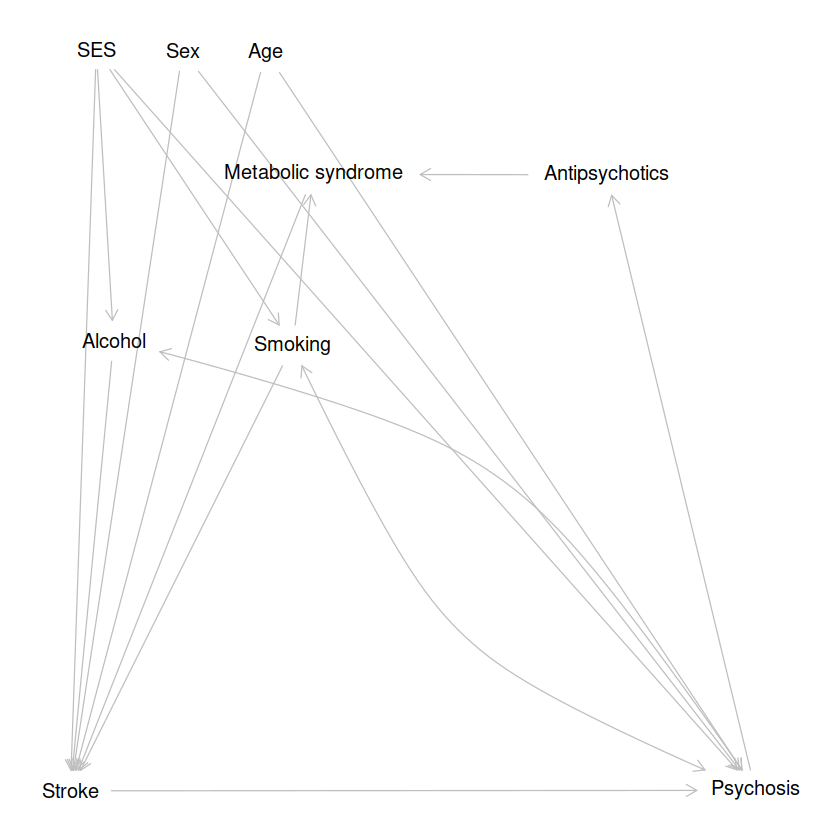

In [1]:
library(dagitty)

g <- downloadGraph("dagitty.net/mPs7RzL")

plot(g)

Test whether there total effect can be estimated by covariate adjustment

In [2]:
adjustmentSets(g, "Stroke", "Psychosis")

No output, so this reports there are no minimal sets of variates that will acheive this

### Regression results reporting associations between stroke and probable psychosis, and stroke and psychotic symptoms

#### Unadjusted and adjusted associations between stroke and probable psychosis

In [26]:
# Calculate probable psychosis results from regression models
#
uk_results <- run_prob_psychosis_models(dataset_apms)
us_results <- run_prob_psychosis_models(dataset_cpes) 
colombia_results <- run_prob_psychosis_models(dataset_ensm) 
chile_results <- run_prob_psychosis_models(dataset_ensc)
combined_results <- run_prob_psychosis_combined_model(dataset_combined)

In [27]:
# Collate results into table and display
#
probpsychosis_regression_table_df <- data.frame("Unadjusted" = character(), "Adjusted" = character())
probpsychosis_regression_table_df[nrow(probpsychosis_regression_table_df)+1,] <- uk_results
probpsychosis_regression_table_df[nrow(probpsychosis_regression_table_df)+1,] <- us_results
probpsychosis_regression_table_df[nrow(probpsychosis_regression_table_df)+1,] <- colombia_results
probpsychosis_regression_table_df[nrow(probpsychosis_regression_table_df)+1,] <- chile_results
probpsychosis_regression_table_df[nrow(probpsychosis_regression_table_df)+1,] <- combined_results

rownames(probpsychosis_regression_table_df) <- name_vec
probpsychosis_regression_table_df

,Unadjusted,Adjusted
,<chr>,<chr>
UK,1.26 (0.31 - 5.17),1.11 (0.15 - 8.26)
US,6.90 (2.83 - 16.81),6.22 (2.52 - 15.35)
Colombia,3.37 (1.77 - 6.42),4.04 (2.10 - 7.78)
Chile,1.33 (0.18 - 9.94),1.33 (0.18 - 10.09)
Combined,3.06 (1.93 - 4.85),3.32 (2.05 - 5.38)


#### Unadjusted and adjusted associations between stroke and paranoia

In [28]:
# Calculate paranoia results from regression models
#
uk_results <- run_paranoia_models(dataset_apms)
us_results <- run_paranoia_models(dataset_cpes)
colombia_results <- run_paranoia_models(dataset_ensm)
chile_results <- run_paranoia_models(dataset_ensc)
combined_results <- run_paranoia_combined_model(dataset_combined)

In [29]:
# Collate results into table and display
#
paranoia_regression_table_df <- data.frame("Unadjusted" = character(), "Adjusted" = character())
paranoia_regression_table_df[nrow(paranoia_regression_table_df)+1,] <- uk_results
paranoia_regression_table_df[nrow(paranoia_regression_table_df)+1,] <- us_results
paranoia_regression_table_df[nrow(paranoia_regression_table_df)+1,] <- colombia_results
paranoia_regression_table_df[nrow(paranoia_regression_table_df)+1,] <- chile_results
paranoia_regression_table_df[nrow(paranoia_regression_table_df)+1,] <- combined_results

rownames(paranoia_regression_table_df) <- name_vec
paranoia_regression_table_df

,Unadjusted,Adjusted
,<chr>,<chr>
UK,0.63 (0.32 - 1.23),0.99 (0.46 - 2.16)
US,2.71 (1.07 - 6.82),2.50 (0.99 - 6.34)
Colombia,2.01 (1.27 - 3.20),2.34 (1.46 - 3.74)
Chile,1.92 (0.59 - 6.26),1.71 (0.52 - 5.66)
Combined,1.38 (1.00 - 1.90),1.66 (1.19 - 2.32)


#### Unadjusted and adjusted associations between stroke and hallucinated voices

In [30]:
# Calculate hallucinated voices from regression models
#
uk_results <- run_hearvoices_models(dataset_apms)
us_results <- run_hearvoices_models(dataset_cpes)
colombia_results <- run_hearvoices_models(dataset_ensm)
chile_results <- run_hearvoices_models(dataset_ensc)
combined_results <- run_hearvoices_combined_model(dataset_combined)

In [31]:
# Collate results into table and display
#
hearvoices_regression_table_df <- data.frame("Unadjusted" = character(), "Adjusted" = character())
hearvoices_regression_table_df[nrow(hearvoices_regression_table_df)+1,] <- uk_results
hearvoices_regression_table_df[nrow(hearvoices_regression_table_df)+1,] <- us_results
hearvoices_regression_table_df[nrow(hearvoices_regression_table_df)+1,] <- colombia_results
hearvoices_regression_table_df[nrow(hearvoices_regression_table_df)+1,] <- chile_results
hearvoices_regression_table_df[nrow(hearvoices_regression_table_df)+1,] <- combined_results

rownames(hearvoices_regression_table_df) <- name_vec
hearvoices_regression_table_df

,Unadjusted,Adjusted
,<chr>,<chr>
UK,0.60 (0.08 - 4.32),0.85 (0.11 - 6.29)
US,2.33 (1.41 - 3.86),2.03 (1.22 - 3.38)
Colombia,4.30 (2.20 - 8.41),4.06 (2.05 - 8.03)
Chile,0.71 (0.22 - 2.26),0.71 (0.22 - 2.29)
Combined,2.01 (1.39 - 2.90),1.89 (1.30 - 2.74)


####  Unadjusted and adjusted associations between stroke and thought passivity delusions

In [32]:
# Calculate thought passivity delusions results from regression models
#
uk_results <- run_thoughtpass_models(dataset_apms)
us_results <- run_thoughtpass_models(dataset_cpes)
colombia_results <- run_thoughtpass_models(dataset_ensm)
chile_results <- run_thoughtpass_models(dataset_ensc)
combined_results <- run_thoughtpass_combined_model(dataset_combined)

In [33]:
# Collate results into table and display
#
thoughtpass_regression_table_df <- data.frame("Unadjusted" = character(), "Adjusted" = character())
thoughtpass_regression_table_df[nrow(thoughtpass_regression_table_df)+1,] <- uk_results
thoughtpass_regression_table_df[nrow(thoughtpass_regression_table_df)+1,] <- us_results
thoughtpass_regression_table_df[nrow(thoughtpass_regression_table_df)+1,] <- colombia_results
thoughtpass_regression_table_df[nrow(thoughtpass_regression_table_df)+1,] <- chile_results
thoughtpass_regression_table_df[nrow(thoughtpass_regression_table_df)+1,] <- combined_results

rownames(thoughtpass_regression_table_df) <- name_vec
thoughtpass_regression_table_df

,Unadjusted,Adjusted
,<chr>,<chr>
UK,1.07 (0.26 - 4.40),0.67 (0.09 - 4.94)
US,2.17 (0.52 - 9.16),2.12 (0.50 - 9.00)
Colombia,3.52 (1.89 - 6.55),4.27 (2.27 - 8.03)
Chile,2.09 (0.28 - 15.87),2.17 (0.28 - 16.95)
Combined,2.51 (1.52 - 4.14),2.68 (1.59 - 4.52)


### Analysis platform details and software versions

In [34]:
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          0.3                         
year           2020                        
month          10                          
day            10                          
svn rev        79318                       
language       R                           
version.string R version 4.0.3 (2020-10-10)
nickname       Bunny-Wunnies Freak Out     

In [35]:
packageVersion("dplyr")

[1] ‘1.0.7’

In [36]:
packageVersion("foreign")

[1] ‘0.8.79’

In [37]:
packageVersion("table1")

[1] ‘1.2.1’

In [38]:
packageVersion("jtools")

[1] ‘2.1.2’

In [39]:
packageVersion("epiR")

[1] ‘2.0.31’

In [40]:
packageVersion("lme4")

[1] ‘1.1.26’

In [41]:
packageVersion("IRdisplay")

[1] ‘0.7.0’